<a href="https://colab.research.google.com/github/james-lucius/qureca_ADEQUATE/blob/main/M9_371_QNNs_3_7_Example_Bars_and_Stripes_Data_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://gitlab.com/qworld/qeducation/educational-materials/adequate-qbook1/raw/main/qworld/images/adq_1.png" align="left" width=450>

_prepared by Claudia Zendejas-Morales_

## 3.7 Example: Bars and Stripes Data Distribution

Let's look at a complete example using [PennyLane](https://pennylane.ai/).

We'll be working with the Bars and Stripes dataset, a simplified version of the one used [here](https://arxiv.org/pdf/2403.07059). The elements in this dataset will be black and white images of $n\times n$ pixels that display either vertical bars or horizontal stripes.

The goal of our QCBM is to learn from the distribution of the Bars and Stripes dataset and be able to generate data from it.

Setting up the environment:

In [5]:
!pip install pennylane==0.40.0 &> /dev/null   # use "&> /dev/null" so that the standard output of the installation is not displayed

print("Setup completed")

Setup completed


Let's first create a function that generates binary representations of images with bars and stripes of size $n\times n$:

In [6]:
import numpy as np


def get_bars_and_stripes(n):

    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]    # generate the bitstrings that represent the numbers
                                                                            # from 0 to 2^n (exclusive) and invert them
                                                                            # e.g.: i=3 => '011' => ['1', '1', '0']
    bitstrings = np.array(bitstrings, dtype=int)                            # convert to integer type, e.g.: => [1, 1, 0]

    bars = bitstrings.copy()                                                # start from a copy of the array
    bars = np.repeat(bars, n, 0)                                            # make n copies of each 'bitstring' to generate n x n data for each bar
                                                                            # e.g.: [1, 1, 0] => [[1, 1, 0]
                                                                            #                     [1, 1, 0]
                                                                            #                     [1, 1, 0]]
    bars = bars.reshape(2**n, n * n)                                        # generate a single list for each image with a bar (flatten the data)
                                                                            # e.g.: => [1, 1, 0, 1, 1, 0, 1, 1, 0]

    stripes = bitstrings.copy()                                             # start from a copy of the array
    stripes = stripes.reshape(2**n * n, 1)                                  # reshape the data from horizontal to vertical
    stripes = np.repeat(stripes, n, 1)                                      # make n copies of each 'bitstring' to generate n x n data for each stripe
    stripes = stripes.reshape(2**n, n * n)                                  # generate a single list for each image with a stripe (flatten the data)

    return np.vstack((bars[0 : bars.shape[0] - 1], stripes[1 : stripes.shape[0]]))    # return both bars and stripes
                                                                                      #    - from the list of bars we remove the last element that
                                                                                      #      contains an array with only zeros (black image only)
                                                                                      #    - from the list of stripes we remove the first element that
                                                                                      #      contains an array with only ones (white image only)

We will generate a dataset with $n=3$, which will imply that each image contains $9$ binary values to represent it, implying the use of $9$ qubits.

In [7]:
n = 3

size = n**2                         # number of bits per image

data = get_bars_and_stripes(n)      # dataset

print(data.shape)

(14, 9)


Let's look at the generated dataset:

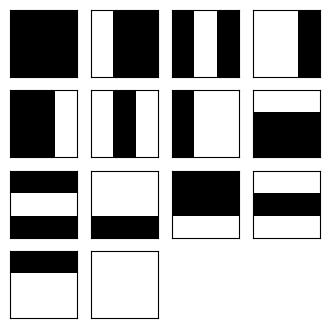

In [8]:
import matplotlib.pyplot as plt


plt.figure(figsize=(4, 4))              # display rows with 4 images
j = 1
for i in data:                          # show all samples
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(                         # display data as an image
        np.reshape(i, (n, n)),          # reshape the flattened image ​​to be nxn pixels
        cmap="gray", vmin=0, vmax=1)    # black and white image
    plt.xticks([])
    plt.yticks([])

We can see that we have all the possibilities for bars and stripes, and since we do not repeat the all-black image nor the all-white image, we end up with $14$ samples in our dataset.

Let's see what the binary representation of a sample is like, let's take the second one as an example:


Sample bitstring: 100100100


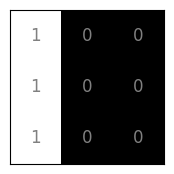

In [9]:
sample = data[1].reshape(n, n)                    # reshape the flattened image ​​to be nxn pixels

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap="gray", vmin=0, vmax=1)   # display data as an image
plt.grid(color="gray", linewidth=2)
plt.xticks([])
plt.yticks([])

# display the binary value for each color (black or white)
for i in range(n):
    for j in range(n):
        text = plt.text(i, j, sample[j][i],
                        ha="center", va="center",
                        color="gray", fontsize=12)

# generate a string with the binary representation of the sample
print(f"\nSample bitstring: {''.join(np.array(sample.flatten(), dtype='str'))}")

Next we compute the integers represented by the valid configurations. We will use them later to evaluate the performance of the QCBM.

In [10]:
bitstrings = []
nums = []

for d in data:
  bitstrings += ["".join(str(int(i)) for i in d)]
  nums += [int(bitstrings[-1], 2)]                  # decimal representation of the bitstrings

print(nums)                                         # 14 numbers, one for each sample

[0, 292, 146, 438, 73, 365, 219, 448, 56, 504, 7, 455, 63, 511]


Let's take the dataset generated to calculate the target probability distribution $\pi(x)$ and visualize it.

We will notice that it is a uniform distribution, and that only the probabilities of the valid configurations (those contained in the dataset) are different from zero.

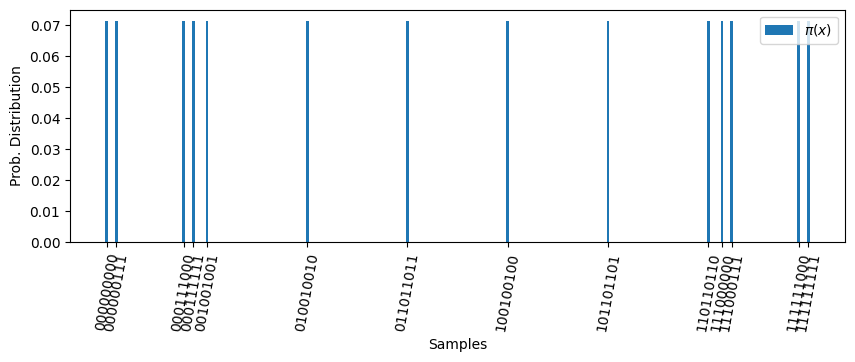

In [11]:
probs = np.zeros(2**size)                                           # probability distribution - array of size 2^{n^2}
probs[nums] = 1 / len(data)                                         # same probability for each element of the dataset

plt.figure(figsize=(10, 4))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$")
plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

$$$$
Now let's prepare what is needed to use a Quantum Circuit Born Machine.
$$$$

To train the QCBM, we will use the next maximum mean discrepancy (MMD) as the loss function (as we saw in section 3.3.1 with some small variations, in this example we are going to take the squared MMD):

$$
L(\boldsymbol{\theta}) = \left | \sum_x p_\theta(x)\phi(x) - \sum_x\pi(x) \phi(x)\right|^2
$$

where $\phi(x)$ maps $x$ to a larger feature space. Using the kernel:

$$K(x,y)=\phi(x)^T\phi(y)$$

allows us to work in a lower-dimensional space. We use the Radial basis function ([RBF](https://en.wikipedia.org/wiki/Radial_basis_function)) kernel for this purpose, which is defined as:

$$
K(x, y) = \frac{1}{c} \sum_{i=1}^c \exp \left(\frac{|x - y|^2}{2\sigma_i^2} \right)
$$

where $\sigma_i$ is the bandwidth parameter controlling the Gaussian kernel's width. $L$ approaches to zero if and only if $p_\theta$ approaches $\pi$.

The we can write the loss function in terms of $K(x,y)$ as follows:

$$
L(\boldsymbol{\theta})=\underset{x\sim p_\theta, y \sim p_\theta}{\mathbb{E}} \left[ K(x, y) \right] - 2 \; \underset{x \sim p_\theta, y \sim \pi}{\mathbb{E}} \left[ K(x, y) \right] + \underset{x \sim \pi, y \sim \pi}{\mathbb{E}} \left[ K(x, y) \right]
$$

$$$$

Using this, let's look at the code for the MMD loss function by creating a class, which will allow us to store the kernel instead of calculating it each time the expected value is needed.

In [12]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)     # added to silence some warnings


class MMD:

    def __init__(self, sigmas, space):
        gammas = 1 / (2 * (sigmas**2))
        sq_dists = jnp.abs(space[:, None] - space[None, :]) ** 2
        self.K = sum(jnp.exp(-gamma * sq_dists) for gamma in gammas) / len(sigmas)
        self.sigmas = sigmas

    def k_expval(self, px, py):
        return px @ self.K @ py               # kernel expectation value

    def __call__(self, px, py):
        pxy = px - py
        return self.k_expval(pxy, pxy)

As you may have noticed, we're using [JAX](https://docs.jax.dev/), a powerful scientific computing library that provides many useful transformations for QML and can be [used directly with PennyLane](https://pennylane.ai/qml/demos/tutorial_jax_transformations).

Note that JAX has its own version of NumPy, and to distinguish it, we import it as `jnp`.

Now let's make a class for the logic of QCBM, it will contain a quantum circuit and the loss function to minimize.

In [13]:
from functools import partial


class QCBM:

    def __init__(self, circ, mmd, py):
        self.circ = circ
        self.mmd = mmd
        self.py = py                        # target distribution π(x)

    @partial(jax.jit, static_argnums=0)
    def mmd_loss(self, params):
        px = self.circ(params)
        return self.mmd(px, self.py), px

We use `jax.jit` because it allows us to compile and optimize simulations for our quantum circuit. With this transformation ([just-in-time compilation](https://docs.jax.dev/en/latest/_autosummary/jax.jit.html)), JAX compiles its execution to [XLA](https://openxla.org/xla).

The `functools.partial` annotation returns a new partial object that, when called, will behave as specified in the first argument, in this case like `jax.jit`. The [partial()](https://docs.python.org/es/3.9/library/functools.html#functools.partial) method is used to apply partial functions that freeze a portion of a function's arguments, resulting in a new object with a simplified signature. For more details, visit the links.

$$$$

Now let's write a parameterized quantum circuit, which we are going to train.

In [14]:
import pennylane as qml

np.random.seed(42)


n_qubits = size                                               # was defined as 2^n, where n comes from the size of the image: n x n

dev = qml.device("default.qubit", wires=n_qubits)


n_layers = 6                                                  # layers for the variational form

@qml.qnode(dev)
def circuit(weights):

    qml.StronglyEntanglingLayers(weights=weights, ranges=[1] * n_layers, wires=range(n_qubits))

    return qml.probs()                                        # we return the probabilities


jit_circuit = jax.jit(circuit)                                # compile the circuit with JAX

Let's create objects from our `MMD` and `QCBM` classes. For the oppressor, we'll use Adam from the [Optax](https://optax.readthedocs.io/en/latest/) package (a gradient processing and optimization library for JAX).

In [15]:
import optax


bandwidth = jnp.array([0.25, 0.5, 1])                       # represented by 'sigma' in the equations

space = jnp.arange(2**n_qubits)                             # size of the space we are working with (number of possible quantum states)
                                                            # same length as array 'probs'


mmd = MMD(bandwidth, space)                                 # the loss function

qcbm = QCBM(jit_circuit, mmd, probs)                        # our Quantum Circuit Born Machine



wshape = qml.StronglyEntanglingLayers.shape(                # define the weights' shape that the StronglyEntanglingLayers variational form expects
    n_layers=n_layers,
    n_wires=n_qubits)

weights = np.random.random(size=wshape)                     # initial values ​​for the trainable parameters (random)

opt = optax.adam(learning_rate=0.1)                         # Adam optimizer

opt_state = opt.init(weights)                               # set initial weights to the optimizer

Let's check that the expected value calculated using the circuit (first expression of $L$), is equal to that calculated with the second expression of $L$.

In [16]:
loss_1, px = qcbm.mmd_loss(weights)       # squared MMD

loss_2 = mmd.k_expval(px, px) - 2 * mmd.k_expval(px, probs) + mmd.k_expval(probs, probs)

print(loss_1)
print(loss_2)

0.06842073068350442
0.06842073068350445


Let's define a function for the calculations at each training step. In `update_step` we find several things:

In [17]:
@jax.jit
def update_step(params, opt_state):

    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss, has_aux=True)(params)   # calculate the squared MMD and its gradients

    updates, opt_state = opt.update(grads, opt_state)                                         # update the optimizer

    params = optax.apply_updates(params, updates)                                             # update the trainable parameters (weights)

    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))                # calculate the KL divergence

    return params, opt_state, loss_val, kl_div                                                # return the new values

The [Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) is a measure of how far the predicted distribution $p_\theta(x)$ is from the target distribution $\pi(x)$.

Now let's perform the training by running our `update_step` for several iterations (epochs).

In [18]:
history = []                        # to store the history
divs = []                           # to store the divergences

n_iterations = 100                  # iterations (epochs)



for i in range(n_iterations):

    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)      # run an update step

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")           # show the progress

    history.append(loss_val)

    divs.append(kl_div)

Step: 0 Loss: 0.0684 KL-div: 4.0735
Step: 10 Loss: 0.0439 KL-div: 1.7351
Step: 20 Loss: 0.0367 KL-div: 1.3296
Step: 30 Loss: 0.0292 KL-div: 1.0619
Step: 40 Loss: 0.0116 KL-div: 0.4977
Step: 50 Loss: 0.0039 KL-div: 0.2462
Step: 60 Loss: 0.0014 KL-div: 0.1348
Step: 70 Loss: 0.0009 KL-div: 0.1077
Step: 80 Loss: 0.0006 KL-div: 0.0852
Step: 90 Loss: 0.0004 KL-div: 0.0755


Now let's visualize the training results:

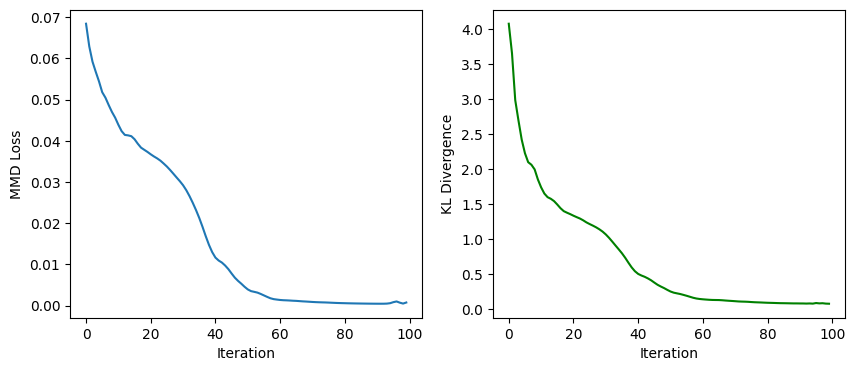

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(history)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("MMD Loss")

ax[1].plot(divs, color="green")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("KL Divergence")
plt.show()

Now let's visualize the target probability distribution $\pi(x)$, along with the predictions from our QCBM (predicted distribution $p_\theta(x)$):

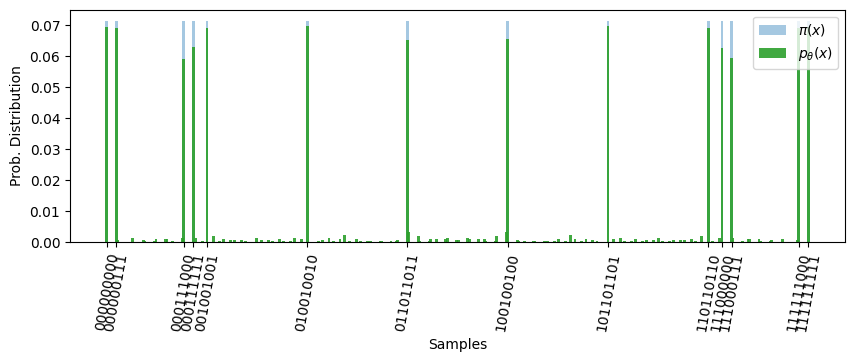

In [20]:
plt.figure(figsize=(10, 4))

qcbm_probs = np.array(qcbm.circ(weights))

plt.bar(np.arange(2**size), probs,
        width=2.0, label=r"$\pi(x)$", alpha=0.4, color="tab:blue")

plt.bar(np.arange(2**size), qcbm_probs,
        width=2.0, label=r"$p_\theta(x)$", alpha=0.9, color="tab:green")


plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.xticks(nums, bitstrings, rotation=80)
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

We can observe that the predictions are a good approximation of the original distribution.

$$$$

To test the training results, we'll take the resulting weights (values remaining at the end of the iterations) and send them to a new quantum circuit (with the same variational form and a different type of measurement), so that the sample it generates falls within the bars and stripes distribution.

We'll calculate $\chi=P(x\text{ is a bar or a stripe})$, which is a measure of the quality of the results generated by this second circuit that uses the already trained parameters.

In [21]:
def circuit_test(weights):
    qml.StronglyEntanglingLayers(weights=weights, ranges=[1] * n_layers, wires=range(n_qubits))
    return qml.sample()


for N in [2000, 20000]:                                             # try these shots values

    dev = qml.device("default.qubit", wires=n_qubits, shots=N)
    circ = qml.QNode(circuit_test, device=dev)
    preds = circ(weights)                                           # test circuit predictions, using the already trained weights

    mask = np.any(np.all(preds[:, None] == data, axis=2), axis=1)   # check for row-wise equality

    chi = np.sum(mask) / N                                          # calculate the quality of the result

    print(f"χ for N = {N}: {chi:.4f}")


χ for N = 2000: 0.9280
χ for N = 20000: 0.9298


Let's look at some of the previously generated samples. Those that represent invalid images (not bars or stripes) will be marked with a red outline.

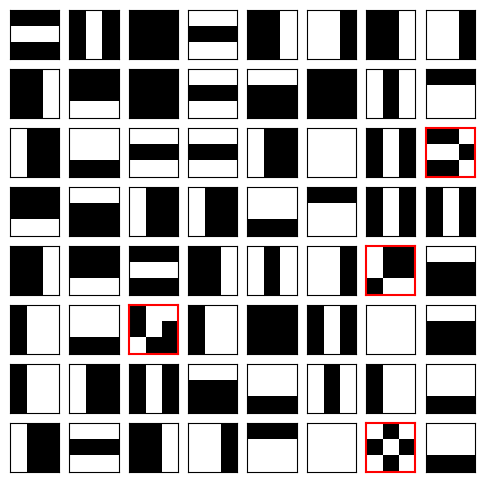

In [22]:
plt.figure(figsize=(6, 6))

j = 1
for i, m in zip(preds[:64], mask[:64]):

    ax = plt.subplot(8, 8, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)

    if ~m:
        plt.setp(ax.spines.values(), color="red", linewidth=1.5)

    plt.xticks([])
    plt.yticks([])